In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from tqdm.auto import tqdm

# Dataset Exploration
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

> The sklearn.datasets.fetch_20newsgroups function is a data fetching / caching functions that downloads the data archive from the original 20 newsgroups website, extracts the archive contents in the ~/scikit_learn_data/20news_home folder and calls the sklearn.datasets.load_files on either the training or testing set folder, or both of them

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])

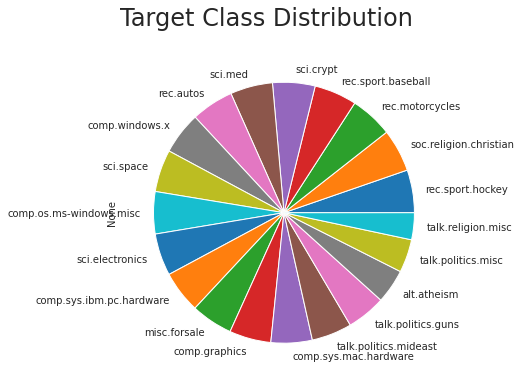

In [3]:
fig, ax = plt.subplots(figsize=(20, 6))
fig.suptitle('Target Class Distribution', fontsize=24)
y.apply(lambda i: dataset['target_names'][i]).value_counts().plot.pie()

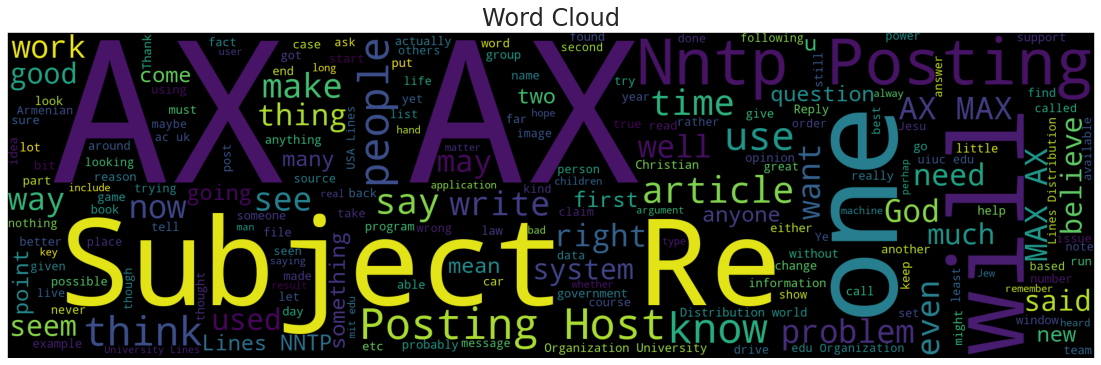

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
wordcloud = WordCloud(height=600, width=2000, stopwords=STOPWORDS).generate(' '.join((X.values)))
ax.imshow(wordcloud)
ax.set_title('Word Cloud', fontsize=24)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Text Cleaning
* remove all punctuation marks and numbers from the documents and lower case the text
* remove words with less than 3 characters

In [5]:
import re
X = X.apply(lambda text: re.sub(r"\s+", " ", re.sub(r"[^A-Za-z]", " ", text)).lower())
X = X.apply(lambda text: ' '.join(x for x in text.split() if len(x) > 2) )

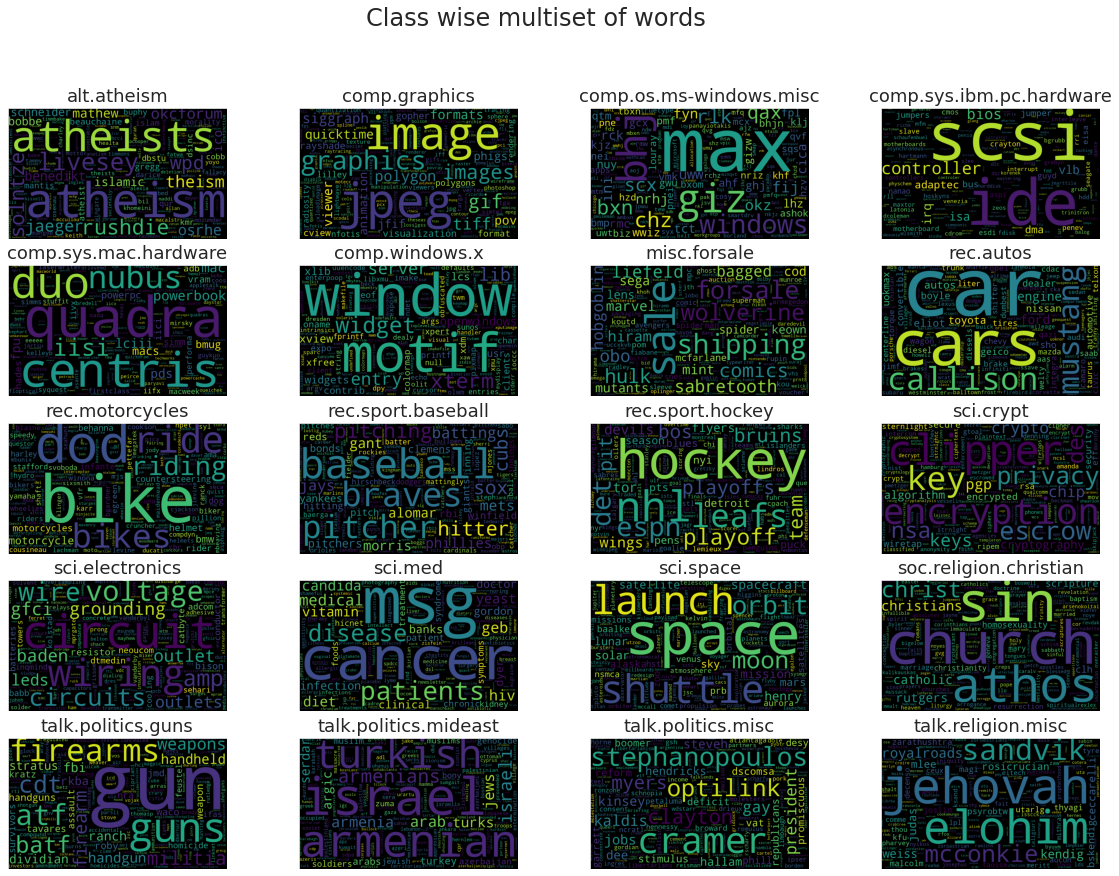

In [6]:
fig, ax = plt.subplots(5, 4, figsize=(20, 14))
fig.suptitle('Class wise multiset of words', fontsize=24)
for i in range(20):
    u = Counter((' '.join((X[y != i].values))).split())
    a = Counter((' '.join((X[y == i].values))).split())
    wordcloud = WordCloud(height=600, width=1000, stopwords=STOPWORDS).generate_from_frequencies((a-u))
    ax[i//4][i%4].imshow(wordcloud)
    ax[i//4][i%4].set_title(f'{dataset["target_names"][i]}', fontsize=18)
    ax[i//4][i%4].xaxis.set_visible(False)
    ax[i//4][i%4].yaxis.set_visible(False) 

# Recurrent Neural Network

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.This makes them applicable to tasks such as Time Series Modellig, Audio/Speech Processing, Natural Language Processing

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png)
<center>Unfolded basic recurrent neural network</center>
<br>

Taking the simplest form of a recurrent neural network, the activation function is tanh, the weight at the recurrent neuron is Whh and the weight at the input neuron is Wxh, we can write the equation for the state at time t as:

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/12/06005300/eq2.png)

The Recurrent neuron in this case is just taking the immediate previous state into consideration. For longer sequences the equation can involve multiple such states. Once the final state is calculated we can go on to produce the output

Now, once the current state is calculated we can calculate the output state as:

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/12/06005750/outeq.png)

In conclusion:

* A single time step of the input is supplied to the network i.e. xt is supplied to the network
* We then calculate its current state using a combination of the current input and the previous state i.e. we calculate ht
* The current ht becomes ht-1 for the next time step
* We can go as many time steps as the problem demands and combine the information from all the previous states
* Once all the time steps are completed the final current state is used to calculate the output yt
* The output is then compared to the actual output and the error is generated
* The error is then backpropagated to the network to update the weights(we shall go into the details of backpropagation in further sections) and the network is trained


## Embedding

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model.

**One-hot encodings**

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

![img](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1)

This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.

**Encode each word with a unique number**

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

There are two downsides to this approach, however:
* The integer-encoding is arbitrary (it does not capture any relationship between words).
* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

**Word embeddings**

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

![img](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1)

## Bidirectional RNNs
For sequences other than time series (e.g. text), it is often the case that a RNN model can perform better if it not only processes sequence from start to end, but also backwards. For example, to predict the next word in a sentence, it is often useful to have the context around the word, not only just the words that come before it.

Reference: 
* [Introduction to Recurrent Neural Networks](https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/)
* [Word Embeddins](https://www.tensorflow.org/tutorials/text/word_embeddings)
* [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)



## Long Short Term Memory

In theory, RNNs are absolutely capable of handling long-term dependencies. A human could carefully pick parameters for them to solve toy problems of this form. Sadly, in practice, RNNs don’t seem to be able to learn them. 

![img](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)
<center>The repeating module in a standard RNN contains a single layer.</center>

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

![img](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
<center>The repeating module in an LSTM contains four interacting layers.</center>
<br><br>

The key to LSTMs is the cell state, the horizontal line running through the top of the diagram. The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates. Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”. An LSTM has three of these gates, to protect and control the cell state.

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.”

![img](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

![img](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

It’s now time to update the old cell state, Ct−1, into the new cell state Ct. The previous steps already decided what to do, we just need to actually do it. We multiply the old state by ft, forgetting the things we decided to forget earlier. Then we add it∗C~t. This is the new candidate values, scaled by how much we decided to update each state value.

![img](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

![img](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

Source: 
[Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Gated Recurrent Unit

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate which adjust the incorporation of new input with the previous memory and an update gate that controls the preservation of the precious memory are introduced. These adaptively control how much each hidden unit remembers or forgets while reading/generating a sequence.

The update gate acts similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add.

The reset gate is another gate is used to decide how much past information to forget.

![img](https://image.slidesharecdn.com/nlpdl06forslideshareenghelvetica-160706022723/95/recent-progress-in-rnn-and-nlp-5-638.jpg?cb=1467843604)

Reference:
[Long Short Term Memory(LSTM) and Gated Recurrent Units(GRU)](https://prvnk10.medium.com/long-short-term-memory-lstm-and-gated-recurrent-units-gru-240d8a62db9)

In [7]:
def plot_model_learning(history, title):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
    df[['loss', 'val_loss']].plot(ax=ax[1])
    ax[0].set_title('Model Accuracy', fontsize=12)
    ax[1].set_title('Model Loss', fontsize=12)
    fig.suptitle(f'{title}: Model Metrics', fontsize=18)

In [8]:
seq_length = int(round(X.apply(lambda x: len(str(x).split())).quantile(0.75)))
print('Sequence Length', seq_length)
vocab_size = len(set(' '.join(X.values).split()))
print('Vocab size', vocab_size)
embedding_vecor_length = 200
MAX_EPOCHS = 100

Sequence Length 231
Vocab size 114363


In [9]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, SimpleRNN, LSTM, GRU, Bidirectional, Dense 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.initializers import Constant

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unw>')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=seq_length)
y = pd.get_dummies(y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 231, 200)          22872600  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 231, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               253440    
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
Total params: 23,131,180
Trainable params: 23,131,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
531/531 [==============================] - ETA: 0s - loss: 2.5072 - accuracy: 0.2060
Epoch 00001: loss improved from inf to 2.50716, saving model to model.h5
531/531 [==============================] - 313s 590ms/step - loss: 2.507

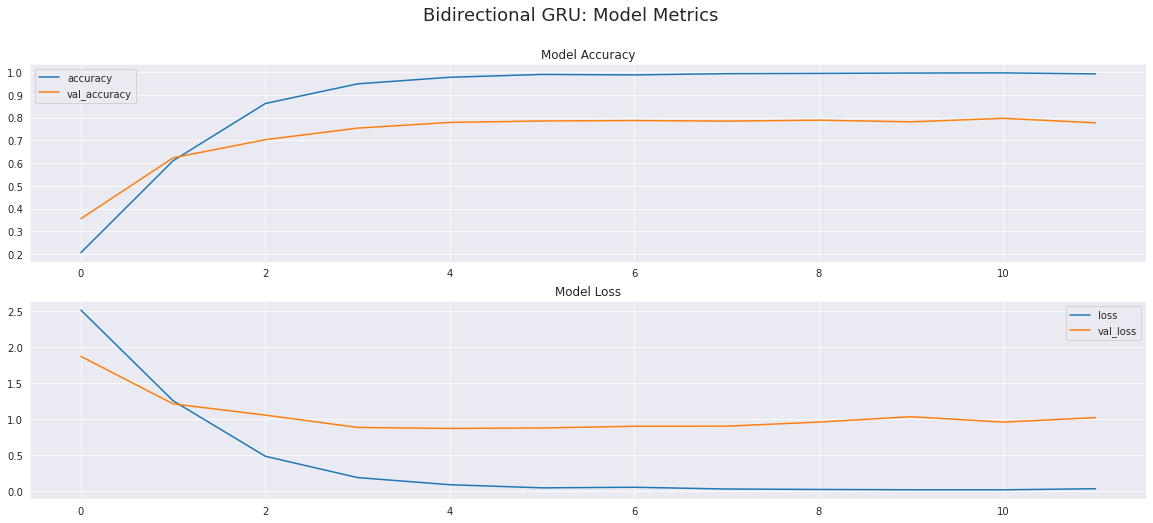

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=seq_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(20, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=MAX_EPOCHS
)
plot_model_learning(history, 'Bidirectional GRU')

# Pre Trained Embeddings

In [12]:
from gensim.models.keyedvectors import KeyedVectors

def prepare_embedding_index(embedding_name):
    embeddings_index = {}
    if embedding_name == 'Word2Vec':
        embeddings_index = KeyedVectors.load_word2vec_format(
            '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True
        )
        embedding_dim = 300

    else:
        if embedding_name == 'Glove':
            f = open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt')
            embedding_dim = 200
        elif embedding_name == 'fastText':
            f = open('../input/fasttext-wikinews/wiki-news-300d-1M.vec')
            embedding_dim = 300
            
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    return embeddings_index, embedding_dim
    
def prepare_embedding_matrix(embeddings_index, embedding_dim, vocab_size, tokenizer):
    count_known = 0
    count_unknown = 0
        
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= vocab_size:
            continue
        embedding_vector = None
        try:
            embedding_vector = embeddings_index[word]
        except:
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            count_known += 1
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
            count_unknown += 1

    print(f'{count_known} known vectors\n{count_unknown} random vectors') 
    return embedding_matrix

## GloVe: Global Vectors for Word Representation

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Reference: [GloVe](https://nlp.stanford.edu/projects/glove/)


64358 known vectors
50004 random vectors
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 231, 200)          22872600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               253440    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 23,131,180
Trainable params: 23,131,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
531/531 [==============================] - ETA: 0s - loss: 2.4271 - accuracy: 0.2515
Epoch 00001: loss improved from inf to 2.42706, saving model to model_glove.h5
531/531 [==============================] - 338s 637ms/step - loss: 2.4271 - accuracy: 0.2515 - val_loss: 1.5016 - val_accuracy: 0.5241
Epoch 2/100
531/531

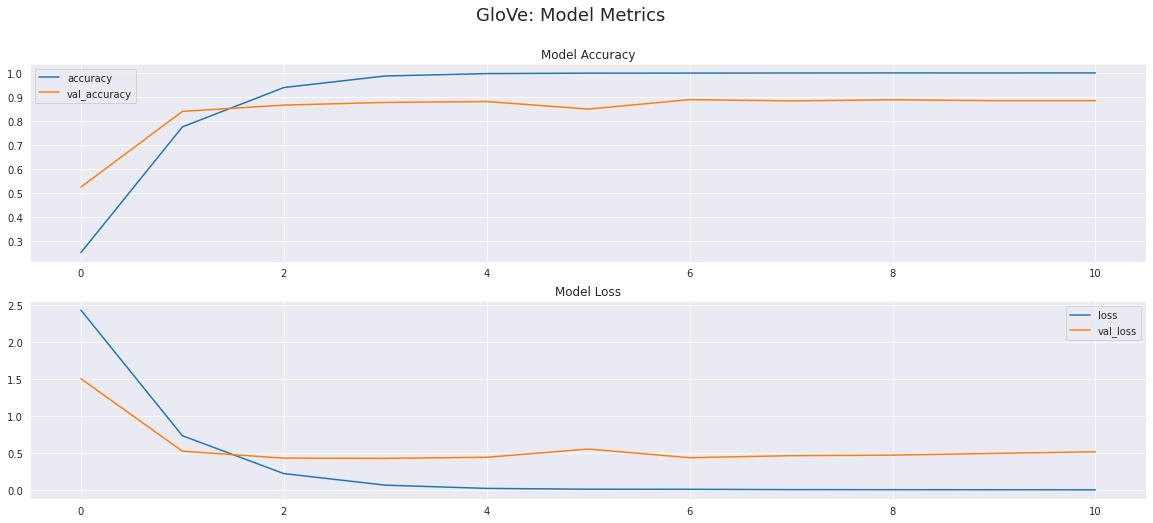

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model_glove.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

embedding_matrix = prepare_embedding_matrix(
    *prepare_embedding_index('Glove'), vocab_size=vocab_size, tokenizer=tokenizer
)

model = Sequential()
model.add(Embedding(
    vocab_size, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix), 
    input_length=seq_length, trainable=True
))
model.add(Bidirectional(GRU(128)))
model.add(Dense(20, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=MAX_EPOCHS 
)
plot_model_learning(history, 'GloVe')

## fastText
FastText is an open-source, free, lightweight library that allows users to learn text representations and text classifiers. It works on standard, generic hardware. Models can later be reduced in size to even fit on mobile devices.

Source: [fastText](https://fasttext.cc/)


56023 known vectors
58339 random vectors
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 231, 300)          34308900  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 34,644,280
Trainable params: 34,644,280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
531/531 [==============================] - ETA: 0s - loss: 2.4660 - accuracy: 0.2523
Epoch 00001: loss improved from inf to 2.46605, saving model to model_fastText.h5
531/531 [==============================] - 481s 905ms/step - loss: 2.4660 - accuracy: 0.2523 - val_loss: 1.7173 - val_accuracy: 0.4451
Epoch 2/100
531/

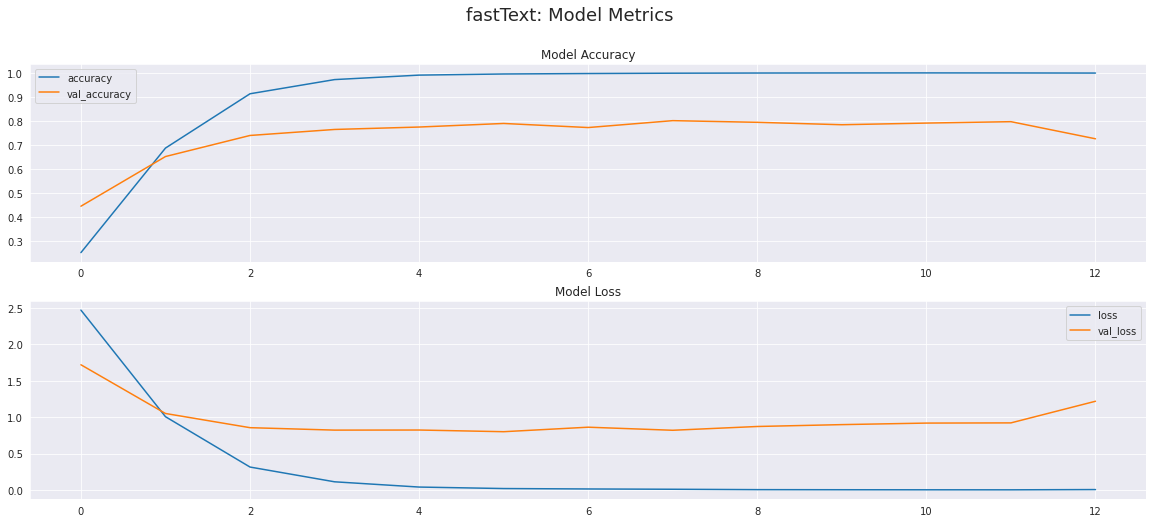

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model_fastText.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

embedding_matrix = prepare_embedding_matrix(
    *prepare_embedding_index('fastText'), vocab_size=vocab_size, tokenizer=tokenizer
)

model = Sequential()
model.add(Embedding(
    vocab_size, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix), 
    input_length=seq_length, trainable=True
))
model.add(Bidirectional(GRU(128)))
model.add(Dense(20, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=MAX_EPOCHS 
)
plot_model_learning(history, 'fastText')

## Word2Vec

Word2Vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through Word2Vec have proven to be successful on a variety of downstream natural language processing tasks.

The papers proposed two methods for learning representations of words:

* **Continuous Bag-of-Words Model** which predicts the middle word based on surrounding context words. The context consists of a few words before and after the current (middle) word. This architecture is called a bag-of-words model as the order of words in the context is not important.
* **Continuous Skip-gram Model** which predict words within a certain range before and after the current word in the same sentence. A worked example of this is given below.

We'll use the skip-gram approach in this task

Source: [Word2Vec](https://www.tensorflow.org/tutorials/text/word2vec)


49147 known vectors
65215 random vectors
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 231, 300)          34308900  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                5140      
Total params: 34,644,280
Trainable params: 34,644,280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
531/531 [==============================] - ETA: 0s - loss: 2.3046 - accuracy: 0.2911
Epoch 00001: loss improved from inf to 2.30456, saving model to model_word2vec.h5
531/531 [==============================] - 491s 925ms/step - loss: 2.3046 - accuracy: 0.2911 - val_loss: 1.5127 - val_accuracy: 0.5088
Epoch 2/100
531/

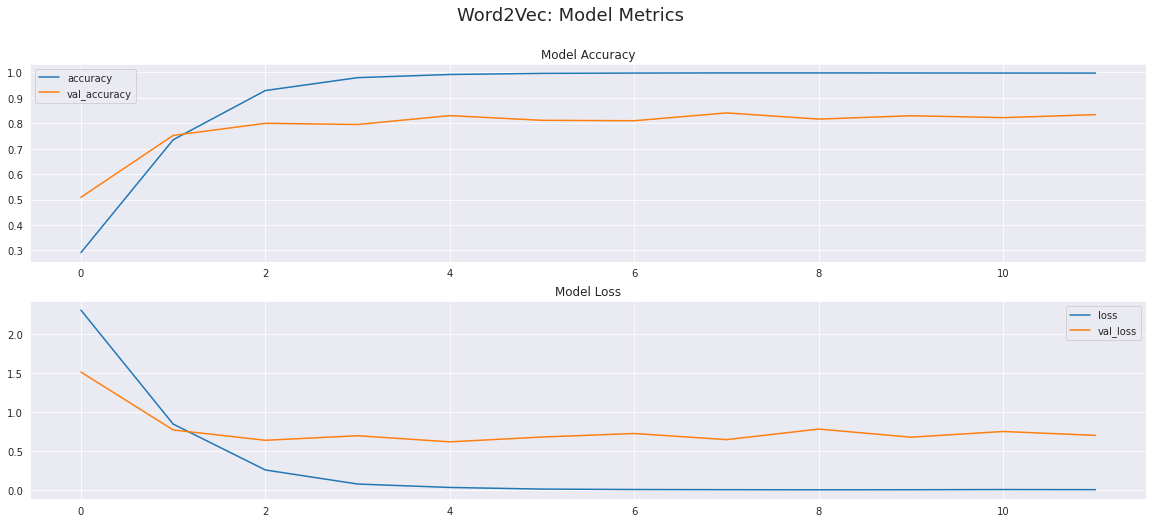

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model_word2vec.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

embedding_matrix = prepare_embedding_matrix(
    *prepare_embedding_index('Word2Vec'), vocab_size=vocab_size, tokenizer=tokenizer
)

model = Sequential()
model.add(Embedding(
    vocab_size, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix), 
    input_length=seq_length, trainable=True
))
model.add(Bidirectional(GRU(128)))
model.add(Dense(20, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=MAX_EPOCHS 
)
plot_model_learning(history, 'Word2Vec')